In [16]:
%cd /home/jnyborg/git/gdd

import pickle as pkl

import json
import os
import random
from copy import deepcopy

import numpy as np
import seaborn as sns
import torch
from torchvision.transforms import Compose
from torch.utils.data import Subset

from torch.utils import data
from tqdm import tqdm
from dataset import PixelSetData, GroupByShapesBatchSampler
from utils.train_utils import to_cuda
from models.stclassifier import PseLTae
from transforms import Normalize, ToTensor, RandomSamplePixels
from utils import label_utils
import torch.nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import time
from sklearn.manifold import TSNE


import torch.nn.functional as F
%matplotlib inline


seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

classes = sorted(['corn', 'horsebeans', 'meadow', 'spring_barley', 'unknown', 'winter_barley', 'winter_rapeseed', 'winter_triticale', 'winter_wheat'])


/home/jnyborg/git/gdd


## Setup model and load weights

In [17]:
device = torch.device('cuda:0')
def get_model(model_dir='outputs/pseltae_32VNH', fold_num=0):
    fold_dir = os.path.join(model_dir, f'fold_{fold_num}')
    best_model_path = os.path.join(fold_dir, 'model.pt')

    with open(os.path.join(model_dir, 'train_config.json')) as f:
        config = json.load(f)

    model = PseLTae(
        input_dim=config['input_dim'],
        num_classes=len(classes),
        with_extra=config['with_extra'],
        with_gdd_extra=config['with_gdd_extra'],
        with_pos_enc=config['with_pos_enc'],
        with_gdd_enc=config['with_gdd_enc'],
        pos_type=config['pos_type'],
    )


    model.to(device)
    model.load_state_dict(torch.load(best_model_path)['state_dict'])
    model.eval()
    print('Restored model weights from', best_model_path)

    return model

In [12]:


transform = Compose([
    RandomSamplePixels(64),  # speedup, but random
    Normalize(),
    ToTensor()
])

#source_data = PixelSetData('/media/data/timematch_data', 'denmark/32VNH/2017', classes=classes, transform=transform)
target_data = PixelSetData('/media/data/timematch_data', 'denmark/32VNH/2017', classes=classes, transform=transform)

In [22]:
@torch.no_grad()
def get_feats(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, num_workers=8, batch_size=256)
    feats = []
    labels = []

    model.eval()
    for sample in tqdm(data_loader):
        target = sample['label']
        labels.extend(target.tolist())
        
        
        _, feat = model(*to_cuda(sample, device), return_feats=True)
        feats.extend(feat.tolist())

    feats = np.array(feats)
    labels = np.array(labels)
    
    return feats, labels

## Visualize embedding

In [29]:
def get_embedded_feats(feats, labels, backbone_name, emb_method='tsne'):
    start = time.time()
    if emb_method == 'tsne':
        tsne = TSNE(random_state=0, learning_rate='auto', init='pca')
        embedded = tsne.fit_transform(feats)
        
    else:
        fit = umap.UMAP(random_state=0, **kwargs)
        embedded = fit.fit_transform(feats)

    print('Embedding done in', time.time() - start)
    embedding_df = pd.DataFrame(
        dict(
            tsne_x=embedded[:, 0],
            tsne_y=embedded[:, 1],
            label=[classes[y] for y in labels],
            method=backbone_name,
        )
    )
    return embedding_df

In [ ]:
target_labels = target_data.get_labels()
target_indices = np.arange(len(target_labels))
indices = []
np.random.seed(42)
n_samples = 1000
for cls_idx in range(len(classes)):
    mask = target_labels == cls_idx
    if mask.sum() < n_samples:
        n = mask.sum()
    else:
        n = n_samples
    choice = np.random.choice(target_indices[mask], size=n, replace=False)
    indices.extend(choice.tolist())

print(len(indices))
    
subset_data = Subset(target_data, indices)

models = [
    'pseltae_AT1+FR1+FR2',
    'pseltae_AT1+FR1+FR2_no_pos',
    'pseltae_AT1+FR1+FR2_shiftaug',
    'pseltae_AT1+FR1+FR2_gdd_sinusoid',
    'pseltae_AT1+FR1+FR2_gdd_fourier'
    
]

embs = []
for model in models:
    feats, labels = get_feats(get_model(f'outputs/{model}', fold_num=0), subset_data)
    emb = get_embedded_feats(feats, labels, model)
    embs.append(emb)

#model = 'pseltae_32VNH'
#feats, labels = get_feats(get_model(f'outputs/{model}', fold_num=0), subset_data, shift=32)
#emb_baseline_shift = get_embedded_feats(feats, labels, model + '_shifted')

#model = 'dann_32VNH_to_30TXT'
#feats, labels = get_feats(get_model(f'outputs/{model}', fold_num=0), subset_data)
#emb_dann = get_embedded_feats(feats, labels, model)

#model = 'upperbound_32VNH_to_30TXT'
#feats, labels = get_feats(get_model(f'outputs/{model}', fold_num=0), subset_data)
#emb_upper = get_embedded_feats(feats, labels, model)

#model = 'timematch_32VNH_to_30TXT'
#feats, labels = get_feats(get_model(f'outputs/{model}', fold_num=0), subset_data)
#emb_timematch = get_embedded_feats(feats, labels, model)

print('done')

7707
Restored model weights from outputs/pseltae_AT1+FR1+FR2/fold_0/model.pt


100%|██████████████████████████| 31/31 [00:03<00:00,  8.42it/s]
/home/jnyborg/miniconda3/envs/utae/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Embedding done in 35.337239027023315
Restored model weights from outputs/pseltae_AT1+FR1+FR2_no_pos/fold_0/model.pt


100%|██████████████████████████| 31/31 [00:03<00:00,  8.47it/s]
/home/jnyborg/miniconda3/envs/utae/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Embedding done in 36.34650444984436
Restored model weights from outputs/pseltae_AT1+FR1+FR2_shiftaug/fold_0/model.pt


100%|██████████████████████████| 31/31 [00:03<00:00,  8.79it/s]
/home/jnyborg/miniconda3/envs/utae/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Embedding done in 39.12167406082153
Restored model weights from outputs/pseltae_AT1+FR1+FR2_gdd_sinusoid/fold_0/model.pt


100%|██████████████████████████| 31/31 [00:03<00:00,  9.51it/s]
/home/jnyborg/miniconda3/envs/utae/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


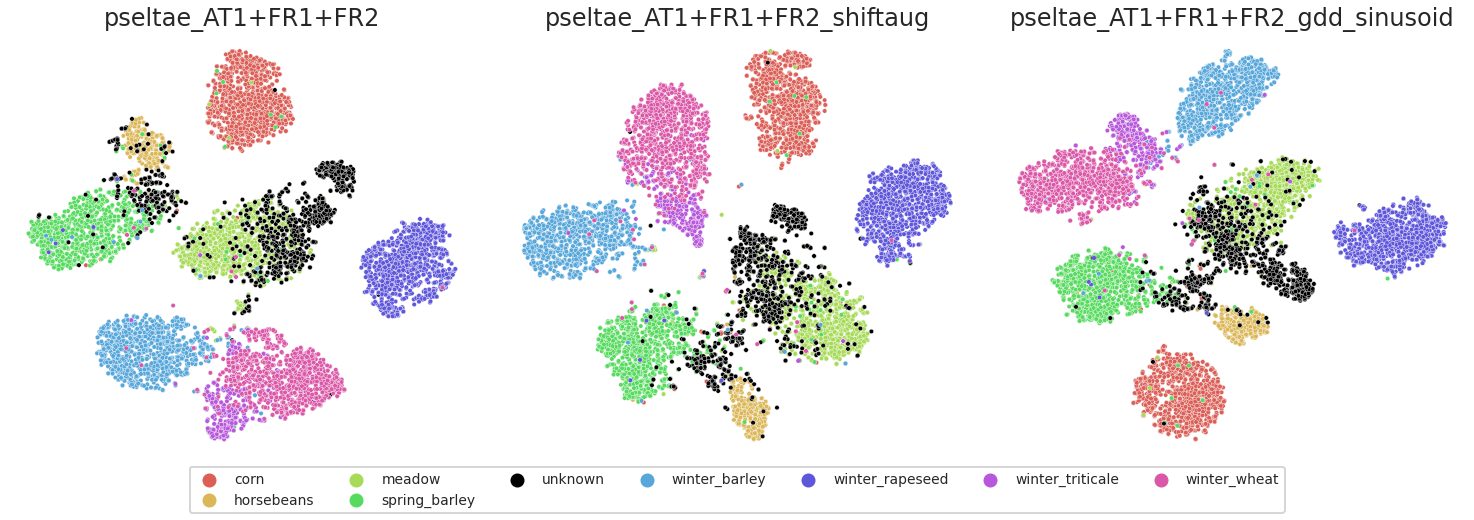

In [39]:
n_figs = len(models)
legend = True
sns.set(style='white', context='poster', rc={'figure.figsize':(7*n_figs,7), 'legend.fontsize':'xx-small'})

colors = sns.color_palette('hls', len(classes))
colors[classes.index('unknown')] = (0,0,0)
s = 20.0

fig, axes = plt.subplots(1, n_figs)

for i, model in enumerate(models):
    ax = axes[i]
    
    last = i == (len(models)-1)
    
    sns.scatterplot(data=embs[i], x='tsne_x', y='tsne_y', hue='label', hue_order=classes, palette=colors, s=s, ax=ax, legend=last)
    ax.axis('off')
    ax.title.set_text(model)
    
    if last:
        fig.legend(loc='center', bbox_to_anchor=(0.5, -0.01), ncol=7)
        ax.get_legend().remove()
        

#ax = axes[i]
#sns.scatterplot(data=emb_baseline_shift, x='tsne_x', y='tsne_y', hue='label', legend=False, hue_order=classes, palette=colors, s=s, ax=ax)
#ax.axis('off')
#ax.title.set_text('Source-Only + Shift')
#i+=1

#ax = axes[i]
#sns.scatterplot(data=emb_dann, x='tsne_x', y='tsne_y', hue='label', legend=False, hue_order=classes, palette=colors, s=s, ax=ax)
#ax.axis('off')
#ax.title.set_text('DANN')
#i+=1

#ax = axes[i]
#sns.scatterplot(data=emb_timematch, x='tsne_x', y='tsne_y', hue='label', legend=False, hue_order=classes, palette=colors, s=s, ax=ax)
#ax.axis('off')
#ax.title.set_text('TimeMatch')
#i+=1

#ax = axes[i]
#g = sns.scatterplot(data=emb_upper, x='tsne_x', y='tsne_y', hue='label', hue_order=classes, palette=colors, s=s, ax=ax, legend=True)
#if legend:
    

#ax.axis('off')
#ax.title.set_text('Target-Only')
plt.tight_layout()
#plt.savefig('tsne.pdf', bbox_inches='tight')
#plt.savefig('tsne.jpeg', bbox_inches='tight', dpi=100)
plt.show()